In [1]:
# Import required libraries

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from time import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import horovod.tensorflow.keras as hvd

2021-11-08 18:07:25.880372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-08 18:07:25.880455: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## CS5488 Project - Price Prediction on Cryptocurrencies
### Project Group 5
<!--
Poon Bing-chun
Jia Shuyue
Li Ka-faat
Tso Yiu-chuen
-->

#### Objective
In this project, we attempt to predict the exchange rates of cryptocurrencies using historical prices of other cryptocurrencies, by training a deep neural network distributedly across several machines.

Distributed training is a collection of techniques for using multiple processors located on different machines for training machine learning models. It is an increasingly important deep learning technique, since it enables the training of wider neural networks which is too cumbersome to manage on one machine only.

#### Plan
The [**Horovod** library](https://github.com/horovod/horovod) ([paper](https://towardsdatascience.com/paper-summary-horovod-fast-and-easy-distributed-deep-learning-in-tensorflow-5be535c748d1)) will be used and the training machines will be grouped by an [**Apache Spark** cluster](https://horovod.readthedocs.io/en/stable/spark_include.html) (which will be covered in the last few weeks of the lecture). Horovod distributes training batches to machines for training, averages the gradients of gradient descents, and aggregates the validation metrics returned by each machine. It supports common deep learning frameworks like **Keras**, **TensorFlow** and **PyTorch**.

We will compare the convergence rates with and without distributed training using TensorBoard.

#### Data Collection

We have written a Python script [**downloadData_5m.py**](https://github.com/verybighub/CS5488_Project/blob/main/downloadData_5m.py) to collect historical cryptocurrency finance data from [https://coinmarketcap.com/](https://coinmarketcap.com/). The date range is 1st January, 2019 to 22nd September, 2021 (i.e. the day we collected the data). We have parsed the data into the machine-readable `pandas` `DataFrame` format and placed it in Google Drive.

In [2]:
from requests import Session

def download_from_google_drive(id):
    URL = "https://docs.google.com/uc?export=download"

    session = Session()

    response = session.get(URL, params = {'id': id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = {'id': id, 'confirm': token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response):
    CHUNK_SIZE = 32768

    with open('historical_coin_data_5m.json', "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

download_from_google_drive('1gkXRtX1BfeC3uxYb6WxGTn2fN5U8S1OZ')

In [2]:
df = pd.read_json('historical_coin_data_5m.json')

In [3]:
df

,Currency,DateTime,Price USD,Trading Volume Last 24h,Market Cap,Price BTC,DunnoWhatThisIs
0,Litecoin,2019-01-01 08:04:00,31.133169,3.800241e+08,1.862125e+09,8.183427e-03,4.894641e+05
1,Bitcoin,2019-01-01 08:04:01,3804.417038,4.637869e+09,6.640638e+10,1.000000e+00,1.745508e+07
2,XRP,2019-01-01 08:04:01,0.360121,5.027181e+08,1.469083e+10,9.465870e-05,3.861520e+06
3,Dogecoin,2019-01-01 08:04:02,0.002367,1.779630e+07,2.784091e+08,6.221000e-07,7.318046e+04
4,Stellar,2019-01-01 08:04:04,0.114630,9.050305e+07,2.196406e+09,3.013080e-05,5.773304e+05
...,...,...,...,...,...,...,...
5124733,Internet Computer,2021-09-22 05:49:10,48.568079,3.332303e+08,7.911265e+09,1.121945e-03,1.827539e+05
5124734,Internet Computer,2021-09-22 05:49:12,48.568079,3.332303e+08,7.911265e+09,1.121945e-03,1.827539e+05
5124735,VeChain,2021-09-22 05:54:14,0.096595,5.599202e+08,6.212570e+09,2.231800e-06,1.435412e+05
5124736,VeChain,2021-09-22 05:54:16,0.096595,5.599202e+08,6.212570e+09,2.231800e-06,1.435412e+05


In [4]:
# Choose a currency
currency = 'Stellar'

# Originally the data has a 5-minute interval
# We can use Python to get hourly interval using this syntax: [::12] because 60 / 5 = 12
# Skip every 12 values
price = df[df['Currency'] == currency]['Price USD'][::12]
vol =  df[df['Currency'] == currency]['Trading Volume Last 24h'][::12]
marketcap =  df[df['Currency'] == currency]['Market Cap'][::12]

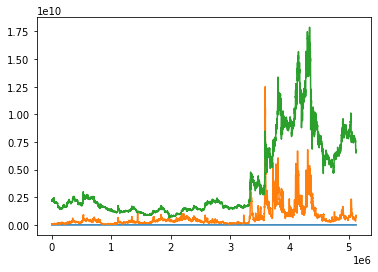

In [5]:
plt.plot(price, label='Price USD')
plt.plot(vol, label='Trading Volume')
plt.plot(marketcap, label='Market Cap')

In [6]:
# From the above chart, the number range is too large, so we will use the log scale instead.
feats=np.dstack([np.log(price[1:] + 1),np.log(vol[1:] + 1),np.log(marketcap[1:] + 1)])[0,:,:]

print(feats.shape)

(23907, 3)


In [7]:
# Data scaling
# Robust scaler: Helps removing outliers
scaler = RobustScaler()
# Min-max normalisation: Scale all features between 0-1: model performs better when numerical input variables are scaled to a standard range
scaler2 = MinMaxScaler()

feats_scaled = scaler2.fit_transform(scaler.fit_transform(feats))
print(feats_scaled)

[[0.14211855 0.11708727 0.3672111 ]
 [0.14188603 0.12124256 0.36684163]
 [0.1430799  0.12651471 0.36873441]
 ...
 [0.40518686 0.50564134 0.70679707]
 [0.40453634 0.49359046 0.70631799]
 [0.40561021 0.48193059 0.70710853]]


In [8]:
# Compared to unscaled below
feats

array([[ 0.10848416, 18.32920716, 21.50971241],
       [ 0.10835836, 18.35236185, 21.50848805],
       [ 0.1090043 , 18.38174006, 21.51476032],
       ...,
       [ 0.2508166 , 20.49436319, 22.63502831],
       [ 0.25046464, 20.42721158, 22.63344073],
       [ 0.25104566, 20.36223881, 22.63606042]])

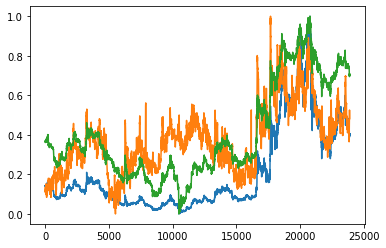

In [9]:
# Plot scaled features
plt.plot(feats_scaled)

In [10]:
# Determine best sliding window size
# size: 3 * 7 => last three days
sliding_window = np.lib.stride_tricks.sliding_window_view(feats_scaled, (5 * 7 + 3 ,3), axis=(0,1))
sliding_window = sliding_window.reshape((sliding_window.shape[0], sliding_window.shape[2], sliding_window.shape[3]))

# Xs: Price, volume, market cap and price of the past week
Xs = np.array([i[:-3] for i in sliding_window])
# Xs: Price of the next three hours
Ys = np.array([i[-3:,0] for i in sliding_window])

print('-----------------------\nXs:\n')
print(Xs)
print('-----------------------\nYs:\n')
print(Ys)
print('-----------------------\nXs:\n')
print(Xs.shape)
print('-----------------------\nYs:\n')
print(Ys.shape)

-----------------------
Xs:

[[[0.14211855 0.11708727 0.3672111 ]
  [0.14188603 0.12124256 0.36684163]
  [0.1430799  0.12651471 0.36873441]
  ...
  [0.14473905 0.11869073 0.3713566 ]
  [0.14469951 0.11600263 0.37129457]
  [0.14517726 0.11634764 0.37204334]]

 [[0.14188603 0.12124256 0.36684163]
  [0.1430799  0.12651471 0.36873441]
  [0.13976798 0.13035038 0.36345719]
  ...
  [0.14469951 0.11600263 0.37129457]
  [0.14517726 0.11634764 0.37204334]
  [0.14483455 0.10062515 0.37150637]]

 [[0.1430799  0.12651471 0.36873441]
  [0.13976798 0.13035038 0.36345719]
  [0.13919871 0.13399596 0.36254171]
  ...
  [0.14517726 0.11634764 0.37204334]
  [0.14483455 0.10062515 0.37150637]
  [0.14445257 0.1041338  0.37090689]]

 ...

 [[0.45203777 0.3657207  0.73984305]
  [0.44435679 0.37352423 0.73461181]
  [0.44647332 0.37718095 0.7360602 ]
  ...
  [0.39486206 0.51207059 0.69912238]
  [0.40029538 0.51482557 0.70318008]
  [0.40265334 0.5118771  0.70492789]]

 [[0.44435679 0.37352423 0.73461181]
  [0.446

# Data splitting
We will use the holdout method. The split percentages are 90% for training, 5% for verification, and 5% for validation.

In [11]:
TrainLen = int(len(Xs) * 0.90)
ValLen = int(len(Xs) * 0.95)
TestLen = len(Xs) - TrainLen

x_train = Xs[0:TrainLen,:]
y_train = Ys[0:TrainLen]

x_val = Xs[TrainLen:ValLen,:]
y_val = Ys[TrainLen:ValLen]

x_test = Xs[ValLen:,:]
y_test = Ys[ValLen:]

y_train = y_train.reshape((y_train.shape[0],y_train.shape[1],1))
y_val = y_val.reshape((y_val.shape[0],y_val.shape[1],1))
y_test = y_test.reshape((y_test.shape[0],y_test.shape[1],1))

In [12]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(21483, 35, 3)
(1193, 35, 3)
(1194, 35, 3)
(21483, 3, 1)
(1193, 3, 1)
(1194, 3, 1)


In [13]:
# Horovod: initialize Horovod
hvd.init()

In [15]:
model = Sequential()
model.add(LSTM(128, dropout=0.05, return_sequences=True))
model.add(LSTM(64, dropout=0.05))
model.add(Dense(3, activation='sigmoid'))

# Horovod: adjust learning rate based on the number of GPUs
scaled_lr = 0.001 * hvd.size()
opt = tf.optimizers.Adam(scaled_lr)
# Horovod: adjust Horovod DistributedOptimizer
opt = hvd.DistributedOptimizer(opt, backward_passes_per_step=1, average_aggregated_gradients=True)


# Horovod: Specify `experimental_run_tf_function=False` to ensure TensorFlow 
# uses hvd.DistributedOptimizer() to compute gradients.
# Adam optimiser allows high learning rate at first and speeds up training
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_squared_error'],experimental_run_tf_function=False)

callbackHs = [
    # Horovod: broadcast initial variable states from rank 0 to all other processes.
    # This is necessary to ensure consistent initialization of all workers when
    # training is started with random weights or restored from a checkpoint.
    hvd.callbacks.BroadcastGlobalVariablesCallback(0),
    
    # Horovod: average metrics among workers at the end of every epoch.
    # Note: This callback must be in the list before the ReduceLROnPlateau,
    # TensorBoard or other metrics-based callbacks.
    hvd.callbacks.MetricAverageCallback(),
    
    # Horovod: using `lr = 1.0 * hvd.size()` from the very beginning leads to worse final
    # accuracy. Scale the learning rate `lr = 1.0` ---> `lr = 1.0 * hvd.size()` during
    # the first three epochs. See https://arxiv.org/abs/1706.02677 for details.
    hvd.callbacks.LearningRateWarmupCallback(initial_lr=scaled_lr, warmup_epochs=3, verbose=1),
]

# Horovod: save checkpoints only on worker 0 to prevent other workers from corrupting them.
if hvd.rank() == 0:
    callbackHs.append(tf.keras.callbacks.ModelCheckpoint('./checkpoint-{epoch}.h5'))

# Horovod: write logs on worker 0.
verbose = 1 if hvd.rank() == 0 else 0

# Early stop to prevent overfitting
callbackEs = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3, verbose=1, restore_best_weights=True)

# Log performance using TensorBoard
callbackTb = tf.keras.callbacks.TensorBoard()

model.fit(x_train, y_train, shuffle=True, epochs=500, verbose=verbose, validation_data=(x_val, y_val), callbacks = [callbackTb, callbackEs,callbackHs])

2021-11-07 17:28:44.840504: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-07 17:28:44.840591: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-07 17:28:44.842802: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-07 17:28:45.048366: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500
  2/672 [..............................] - ETA: 3:26 - loss: 0.1409 - mean_squared_error: 0.1409   

2021-11-07 17:28:51.869344: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-07 17:28:51.869427: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-07 17:28:52.015544: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-07 17:28:52.055272: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-07 17:28:52.191055: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2021_11_07_17_28_52

2021-11-07 17:28:52.248331: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2021_11_07_17_28_52/LAPTOP-0TFTFNMR.trace.json.gz
2021-11-07 17:28:52.294767: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2021_11_07_17_28_52

2021-11-07 17:28:52.303706

672/672 [==============================] - 74s 101ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 4.5030e-04 - val_mean_squared_error: 4.5030e-04
Epoch 2/500
672/672 [==============================] - 58s 86ms/step - loss: 5.2166e-04 - mean_squared_error: 5.2166e-04 - val_loss: 2.5752e-04 - val_mean_squared_error: 2.5752e-04
Epoch 3/500
672/672 [==============================] - 80s 120ms/step - loss: 4.7723e-04 - mean_squared_error: 4.7723e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 4/500
166/672 [======>.......................] - ETA: 46s - loss: 3.8017e-04 - mean_squared_error: 3.8017e-04

KeyboardInterrupt: 

In [15]:
i = model.predict(x_test)
predicted = np.ravel(i)

print(i)
print(y_test)

print(i.shape)
print(y_val.shape)
'''
for x_test:
    model.predict()
'''

[[0.39188284 0.39420378 0.3931553 ]
 [0.39125764 0.3936705  0.39264587]
 [0.39094377 0.39344496 0.39242095]
 ...
 [0.40966818 0.41074413 0.4101563 ]
 [0.40857852 0.4098665  0.4091901 ]
 [0.40744904 0.4088395  0.4081239 ]]
[[[0.39576685]
  [0.39774465]
  [0.39144962]]

 [[0.39774465]
  [0.39144962]
  [0.39457139]]

 [[0.39144962]
  [0.39457139]
  [0.38828655]]

 ...

 [[0.40677995]
  [0.40257796]
  [0.40518686]]

 [[0.40257796]
  [0.40518686]
  [0.40453634]]

 [[0.40518686]
  [0.40453634]
  [0.40561021]]]
(1194, 3)
(1193, 3, 1)


'\nfor x_test:\n    model.predict()\n'

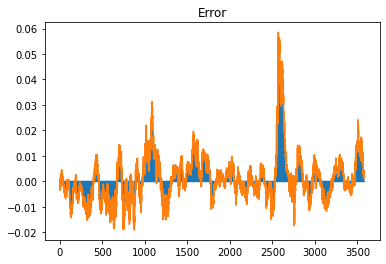

In [16]:
predicted2 = np.ravel(i)
y_test2 = np.ravel(y_test)

plt.title('Error')
# Apply inverse transform to cancel the effects of MinMax scaler and Robust scaler to get back the original
error = scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted2]))[:,0] - scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test2]))[:, 0]
plt.plot(np.arange(len(error)), [0] * len(error))
plt.plot(error)
plt.fill_between(np.arange(len(error)), [0] * len(error), error)

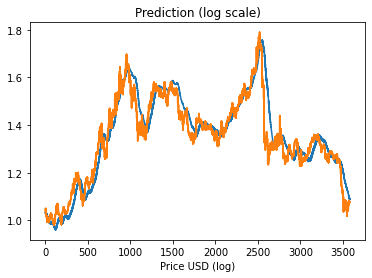

In [17]:
predicted3 = scaler2.inverse_transform([[x,0,0] for x in predicted2])[:,0].ravel()
y_test3 = scaler2.inverse_transform([[x,0,0] for x in y_test2])[:,0].ravel()

plt.title('Prediction (log scale)')
plt.xlabel('Price USD (log)')
plt.plot(predicted3,label="predict")
plt.plot(y_test3,label="real")

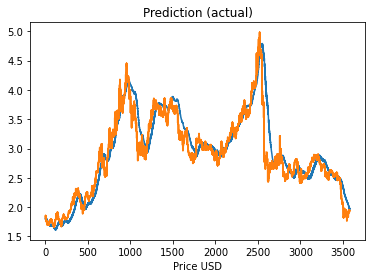

In [18]:
# Undo the log to see the actual price in USD
predicted0 = np.exp(predicted3)-1
y_test0 = np.exp(y_test3)-1

plt.title('Prediction (actual)')
plt.xlabel('Price USD')
plt.plot(predicted0,label="predict")
plt.plot(y_test0,label="real")

In [19]:
for _ in range(100):
    print('--------------------------------------------------------------------')

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
----------------------------------

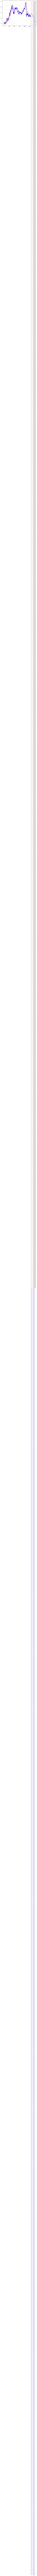

In [20]:
i3 = scaler2.inverse_transform([[x,0,0] for x in predicted2])[:,0].reshape(i.shape)
y_test3 = scaler2.inverse_transform([[x,0,0] for x in y_test2])[:,0].reshape(y_test.shape)

from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
for x in range(len(i3)):
    plt.plot(np.arange(x,x+3), i3[x],'r--',label="predict")
for x1 in range(len(y_test)):
    plt.plot(np.arange(x1,x1+3), y_test3[x1],'b-',label="real")
plt.legend()

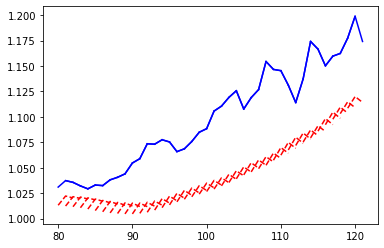

In [21]:
for x in range(80,120):
    plt.plot(np.arange(x,x+3), i3[x],'r--',label="predict")
    plt.plot(np.arange(x,x+3), y_test3[x],'b-',label="real")

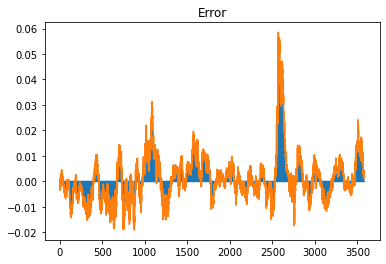

In [22]:
predicted2 = np.ravel(i)
y_test2 = np.ravel(y_test)

plt.title('Error')
error = scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted2]))[:,0] - scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test2]))[:, 0]
plt.plot(np.arange(len(error)), [0] * len(error))
plt.plot(error)
plt.fill_between(np.arange(len(error)), [0] * len(error), error)

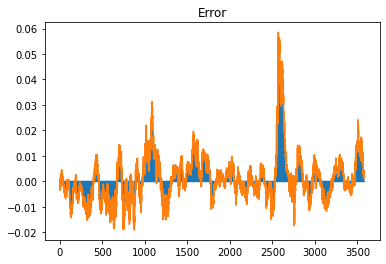

In [23]:
predicted2 = np.ravel(i)
y_test2 = np.ravel(y_test)

plt.title('Error')
error = scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted2]))[:,0] - scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test2]))[:, 0]
plt.plot(np.arange(len(error)), [0] * len(error))
plt.plot(error)
plt.fill_between(np.arange(len(error)), [0] * len(error), error)

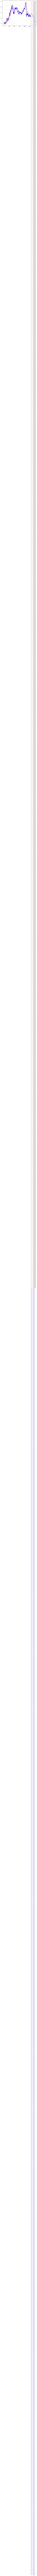

In [25]:
i3 = scaler2.inverse_transform([[x,0,0] for x in predicted2])[:,0].reshape(i.shape)
y_test3 = scaler2.inverse_transform([[x,0,0] for x in y_test2])[:,0].reshape(y_test.shape)

from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
for x in range(len(i3)):
    plt.plot(np.arange(x,x+3), i3[x],'r--',label="predict")
for x1 in range(len(y_test)):
    plt.plot(np.arange(x1,x1+3), y_test3[x1],'b-',label="real")
plt.legend()

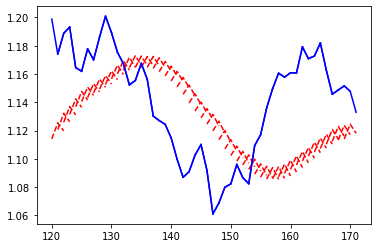

In [26]:
for x in range(120,170):
    plt.plot(np.arange(x,x+3), i3[x],'r--',label="predict")
    plt.plot(np.arange(x,x+3), y_test3[x],'b-',label="real")

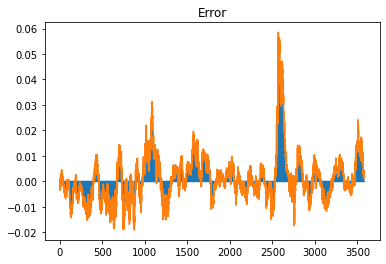

In [27]:
predicted2 = np.ravel(i)
y_test2 = np.ravel(y_test)

plt.title('Error')
error = scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted2]))[:,0] - scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test2]))[:, 0]
plt.plot(np.arange(len(error)), [0] * len(error))
plt.plot(error)
plt.fill_between(np.arange(len(error)), [0] * len(error), error)

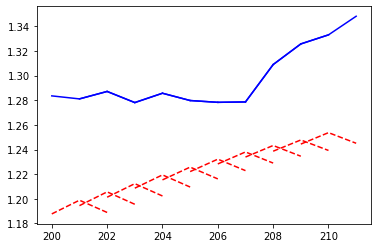

In [28]:
for x in range(200,210):
    plt.plot(np.arange(x,x+3), i3[x],'r--',label="predict")
    plt.plot(np.arange(x,x+3), y_test3[x],'b-',label="real")

In [1]:
i3 = scaler2.inverse_transform([[x,0,0] for x in predicted2])[:,0].reshape(i.shape)
y_test3 = scaler2.inverse_transform([[x,0,0] for x in y_test2])[:,0].reshape(y_test.shape)

from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
for x in range(len(i3)):
    plt.plot(np.arange(x,x+3), i3[x],'r--',label="predict")
for x1 in range(len(y_test)):
    plt.plot(np.arange(x1,x1+3), y_test3[x1],'b-',label="real")
plt.legend()

NameError: name 'scaler2' is not defined

In [2]:
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted]))[:,0], label='predict')
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test]))[:, 0], label='actual')
plt.xlabel('Hours')
plt.ylabel('Price BTC')
plt.legend()

NameError: name 'plt' is not defined

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1194, 3) + inhomogeneous part.

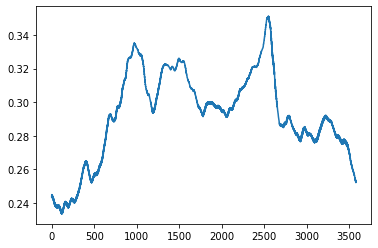

In [33]:
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted]))[:,0], label='predict')
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test]))[:, 0], label='actual')
plt.xlabel('Hours')
plt.ylabel('Price USD')
plt.legend()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1194, 3) + inhomogeneous part.

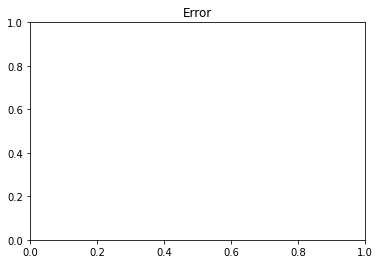

In [34]:
plt.title('Error')
error = scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted]))[:,0] - scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test]))[:, 0]
plt.plot(np.arange(len(error)), [0] * len(error))
plt.plot(error)
plt.fill_between(np.arange(len(error)), [0] * len(error), error)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1194, 3) + inhomogeneous part.

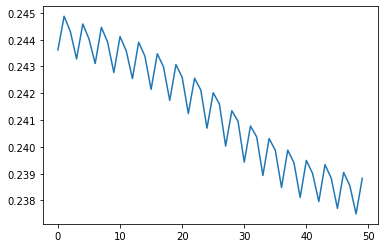

In [35]:
#plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in np.array(a[-946:])]))[:,0], label='predict')
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in predicted2]))[:50,0], label='predict')
plt.plot(scaler.inverse_transform(scaler2.inverse_transform([[x,0,0] for x in y_test]))[:50, 0], label='actual')
plt.xlabel('Hours')
plt.ylabel('Price USD')
plt.legend()